In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast
from scipy.stats import spearmanr, kstest


In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('VAR_Quarentena.csv')


df['date'] = pd.to_datetime(df.date)
df['open_date'] = pd.to_datetime(df.open_date)

df = df.set_index('open_date').loc['2019-01-01':].reset_index()

df['days_open'] = df['days_open'].astype(float)
df['stock1'] = [pair.split("'")[1] for pair in df.pair]

<ipython-input-3-e242945b85d2>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.set_index('open_date').loc['2019-01-01':].reset_index()


In [4]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [5]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [6]:
df.loc[df['residual_open'] < df['std_open_residual'], 'side'] = 'lower'
df.loc[df['residual_open'] > df['std_open_residual'], 'side'] = 'upper'

In [7]:
returns_list = []
i=1
closed = df.loc[df.status=='close']

for row in closed.itertuples():

    historico_par = df.loc[(df.pair==row.pair) & (df.date.between(row.open_date,row.date))].copy()
    historico_par.set_index('date', inplace=True)
    historico_par['id'] = i
    
    
#     display(historico_par)
#     Custo entrada: 1,22% + 0,1% = 1,31%
#     Custo saida: 1,22% + 0,25% + 0,1% = 1,57% + Aluguel
    
#     display(historico_par)
    aluguel = (1.0143)**((row.days_open+2)/252) -1
    try:
        if row.side == 'lower':
            
            historico_par['ratio_sem_custos'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
            
            # Entrada
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1-0.0071)
            
                    
            # Saída
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
        else:
            
            historico_par['ratio_sem_custos'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
            
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock']
            # Entrada
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1-0.0071)

            # Saida
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
        
        
        historico_par['open_price_first_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
        historico_par['open_price_scnd_stock'] = historico_par.at[row.open_date, 'price_scnd_stock']
        
        historico_par['return'] = (historico_par.ratio / historico_par.ratio.shift(1)) -1
        historico_par['retorno_acumulado'] = np.cumprod(1+historico_par['return']) -1
        
        historico_par['return_sem_custos'] = (historico_par.ratio_sem_custos / historico_par.ratio_sem_custos.shift(1)) -1
        historico_par['retorno_acumulado_sem_custos'] = (np.cumprod(1+historico_par['return_sem_custos']) -1)
        
        returns_list.append(historico_par)
        
    except Exception as e:
#         print(e)
        pass
    
    i+=1

In [8]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    if row['residual_open'] < row['std_open_residual']:
        long_result =(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = (row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1
        
        return result, 'lower'
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = (row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = (row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1

        return result, 'upper'

In [9]:
df_returns = pd.concat(returns_list)
df_returns.reset_index(inplace=True)

In [10]:
log_retorno = np.log(1+df_returns.set_index(['date', 'pair', 'open_date','status'])[['return', 'return_sem_custos']]).fillna(0)
retorno_acumulado =  np.exp(log_retorno.cumsum()) - 1
retorno_acumulado.reset_index(inplace=True)

In [11]:
df_returns.halflife.mean()

TypeError: Could not convert DESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADODESLIGADO to numeric

In [13]:
closed = df_returns.loc[df_returns.status=='close']

In [14]:
ibov = pd.read_csv('ibov.csv', usecols=[0,4], index_col=0)
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.loc[df_returns.date.min():df_returns.date.max()]

In [15]:
log_ret_ibov = np.log(ibov/ibov.shift())
ibov_return = ibov/ibov.shift() -1
ibov_retornos = ibov/ibov.shift() -1
cumsum_ibov = np.cumsum(log_ret_ibov)
ibov_pct = np.exp(cumsum_ibov) -1

In [16]:
# Retorno com custos
acumulado_com_custos = np.cumprod(1+df_returns.groupby('date').sum()['return']) -1

In [17]:
# Resultado sem custos por dia
acumulado_sem_custo = np.cumprod(1+df_returns.groupby('date').sum().return_sem_custos) -1


In [18]:
# Operações Fechadas
fechadas = df_returns.loc[df_returns.status=='close']

fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0

retorno_diario = df_returns.groupby('date').sum()

<ipython-input-18-902cf3657bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
<ipython-input-18-902cf3657bf9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0


# Graficos

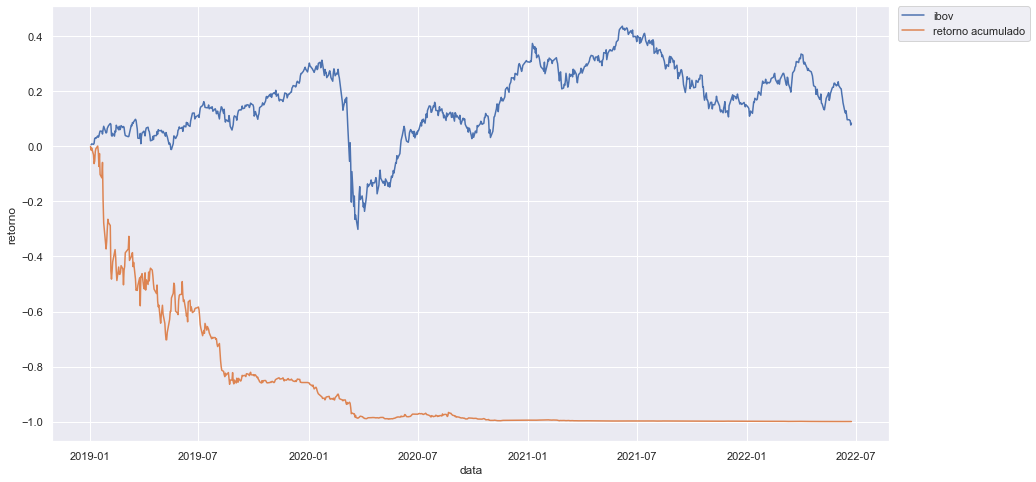

In [19]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_com_custos.index, y=acumulado_com_custos, label='retorno acumulado')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


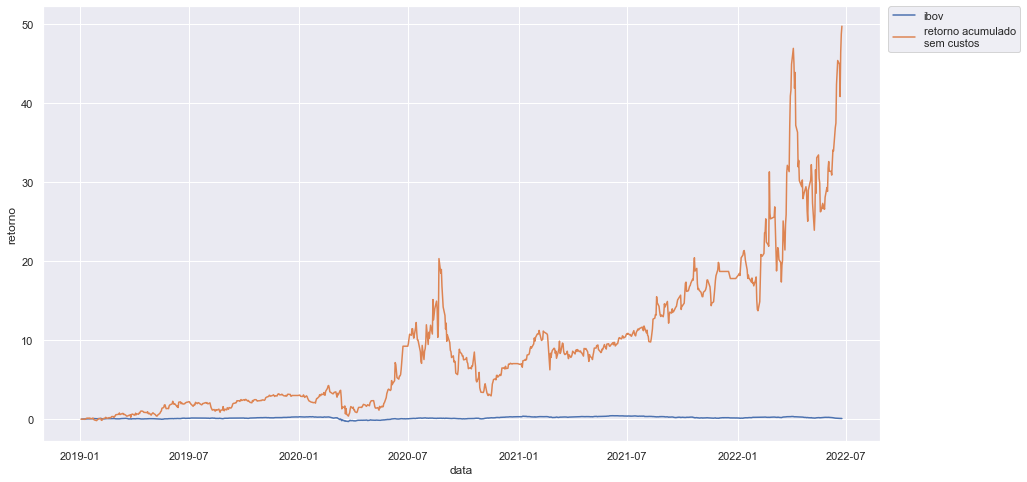

In [20]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_sem_custo.index, y=acumulado_sem_custo, label='retorno acumulado\nsem custos')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [21]:
retornos_diarios = pd.concat([ibov_return, retorno_diario[['return', 'return_sem_custos']]], axis=1)
retornos_diarios.fillna(0, inplace=True)
retornos_diarios.columns = ['ibov', 'retorno_com_custos', 'retorno_sem_custos']

In [22]:
log_retornos = np.log(1+retornos_diarios)
retornos_acumulados = np.exp(log_retornos.cumsum()) -1
retornos_acumulados

,ibov,retorno_com_custos,retorno_sem_custos
2019-01-02,0.000000,0.000000,0.000000
2019-01-03,0.006065,-0.013558,0.000550
2019-01-04,0.009109,-0.005673,0.008547
2019-01-07,0.007548,-0.030467,-0.002651
2019-01-08,0.011207,-0.062533,-0.021626
...,...,...,...
2022-06-20,0.097141,-0.999763,44.929493
2022-06-21,0.095295,-0.999784,40.843595
2022-06-22,0.093504,-0.999759,46.426967
2022-06-23,0.077660,-0.999747,48.754258


# Descritivas

In [23]:
retornos_diarios.describe()

,ibov,retorno_com_custos,retorno_sem_custos
count,864.000000,864.000000,864.000000
mean,0.000262,-0.006112,0.008002
std,0.018215,0.082040,0.083964
min,-0.147797,-0.428056,-0.390771
25%,-0.007783,-0.039827,-0.028684
50%,0.000817,-0.001207,0.004137
75%,0.009629,0.027918,0.040625
max,0.139082,0.587455,0.653969


In [24]:
coeficiente_liquido, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_com_custos']])
print('Correlação de Spearman Resutado líquido: {:0.3}'.format(coeficiente_liquido))

Correlação de Spearman Resutado líquido: 0.0366


In [25]:
coeficiente_bruto, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_sem_custos']])
print('Correlação de Spearman Resutado bruto: {:0.3}'.format(coeficiente_bruto))

Correlação de Spearman Resutado bruto: 0.0335


In [26]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_sem_custos, 'norm')

KstestResult(statistic=0.4157169801053277, pvalue=1.0264292968418294e-135)

In [27]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_com_custos, 'norm')

KstestResult(statistic=0.4173247051204487, pvalue=8.234548350788348e-137)

In [28]:
df_returns['return'].describe()

count    5225.000000
mean       -0.001011
std         0.024928
min        -0.242895
25%        -0.012242
50%        -0.000675
75%         0.010310
max         0.238407
Name: return, dtype: float64

In [29]:
df_returns['return_sem_custos'].describe()

count    5225.000000
mean        0.001323
std         0.025347
min        -0.242895
25%        -0.010688
50%         0.000588
75%         0.012070
max         0.256469
Name: return_sem_custos, dtype: float64

# Eficacia

In [30]:
eficacia = fechadas.set_index('open_date').resample('6M').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)

eficacia

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-01-31,15,0.533333,10.866667
2019-07-31,70,0.685714,19.557143
2020-01-31,49,0.653061,13.326531
2020-07-31,88,0.602273,8.772727
2021-01-31,37,0.621622,14.297297
2021-07-31,39,0.615385,19.820513
2022-01-31,39,0.538462,11.846154
2022-07-31,79,0.582278,8.113924


# Desempenho

In [31]:
vol_ibov = log_ret_ibov.close.std() * math.sqrt(252)
vol_ibov

0.2930617527924815

In [32]:
log_return = np.log(1+retorno_diario['return'])
vol_return = log_return.std() * math.sqrt(252)
vol_return

1.356355630566212

In [33]:
log_return_sem_custo = np.log(1+retorno_diario['return_sem_custos'])
vol_return_sem_custo = log_return_sem_custo.std() * math.sqrt(252)
vol_return_sem_custo

1.337358914381588

In [34]:
retorno_acumulado_bruto = retorno_acumulado['return_sem_custos'].iloc[-1]
taxa_acerto = fechadas['e_lucro_bruto'].mean()
retorno_acumulado_liquido = retorno_acumulado['return'].iloc[-1]

desempenho = pd.DataFrame([{
    'retorno_acumulado_bruto':retorno_acumulado_bruto,
    'taxa_acerto': taxa_acerto,
    'retorno_acumulado_liquido': retorno_acumulado_liquido,
    'desvio_padrao': vol_return,
    'sharpe': retorno_acumulado_liquido/vol_return,
    'correlacao_ibov': coeficiente_liquido
    }])

desempenho

,retorno_acumulado_bruto,taxa_acerto,retorno_acumulado_liquido,desvio_padrao,sharpe,correlacao_ibov
0,189.46556,0.612981,-0.999004,1.356356,-0.736535,0.036593


In [35]:
fechadas.groupby('setor').agg('sum')

,price_fst_stock,price_scnd_stock,beta_open,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,close_limit,...,var_limit,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
setor,,,,,,,,,,,,,,,,,,,,,
Alimentos e Bebidas,129.488542,138.522371,8.492752,-16.358828,14.005609,11.869967,-9.362041,145.632609,142.731268,5.934984,...,-0.321289,1226,6.478981,6.382540,0.122741,-0.102883,0.230597,0.101477,5,4
Aéreas,163.246015,121.714071,3.252073,8.249129,5.340459,4.872339,1.591257,157.715923,124.402328,2.436169,...,-0.139356,567,3.333031,3.284054,-0.185976,-0.241664,-0.115337,-0.130939,1,1
Bens Industriais,157.688172,216.886073,11.677311,-15.535564,11.456478,10.256950,-14.185876,168.946165,223.682025,5.128475,...,-0.428046,2365,11.774521,11.598248,0.020669,-0.026210,0.273537,0.358277,7,7
Construção Civil,44.599705,55.993901,1.824680,0.933690,2.022249,1.788179,0.660991,43.502861,55.264643,0.894089,...,-0.071838,1004,2.966369,2.921860,-0.035479,-0.141640,0.009760,-0.056506,0,0
Educação,4.866909,34.205405,0.322578,1.001371,0.416768,0.386486,0.952488,4.964500,36.728937,0.193243,...,-0.070895,697,14.431603,14.221501,0.118057,-0.073975,0.165089,-0.017573,1,1
Exploração de imóveis,118.624109,164.865352,6.136214,-2.382934,3.281579,3.234337,2.466856,124.650582,166.306313,1.617168,...,-0.162916,1091,6.594177,6.498094,-0.159155,0.023764,-0.015491,0.259163,6,6
Financeiro,2908.088910,3185.530930,229.118886,-30.634727,171.080537,158.060085,-47.685703,2926.164148,3199.400319,79.030043,...,-5.614275,27360,224.509475,221.133395,-0.228843,-2.297238,2.319320,2.274958,91,64
Mineração e Siderurgia,678.371576,476.686855,43.044354,8.121298,26.576120,24.576288,16.273536,669.370468,471.879604,12.288144,...,-0.938017,7197,31.571728,31.105461,-0.241190,-0.845006,0.320257,0.042821,18,11
Papel e Celulose,159.933179,294.270384,3.012716,-0.794471,5.467993,5.596192,0.238764,163.715730,298.236508,2.798096,...,-0.153175,1995,4.505727,4.439278,-0.078712,0.062927,0.011324,0.243131,5,4


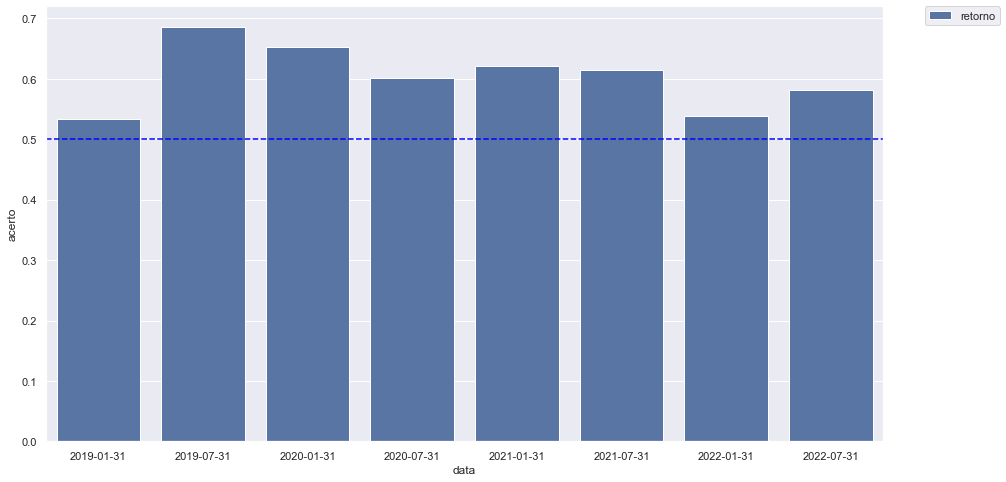

In [36]:
halfyear_accuracy = fechadas.set_index('open_date').resample('6M')[['e_lucro_bruto']].mean().reset_index()
halfyear_accuracy.columns = ['open_date', 'retorno']
halfyear_accuracy['open_date'] = halfyear_accuracy['open_date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='open_date', value_name='acerto')

sns.barplot(x='open_date', y='acerto', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
plt.xlabel('data')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [37]:
halfyear_accuracy

,open_date,variable,acerto
0,2019-01-31,retorno,0.533333
1,2019-07-31,retorno,0.685714
2,2020-01-31,retorno,0.653061
3,2020-07-31,retorno,0.602273
4,2021-01-31,retorno,0.621622
5,2021-07-31,retorno,0.615385
6,2022-01-31,retorno,0.538462
7,2022-07-31,retorno,0.582278


Text(0, 0.5, 'acerto')

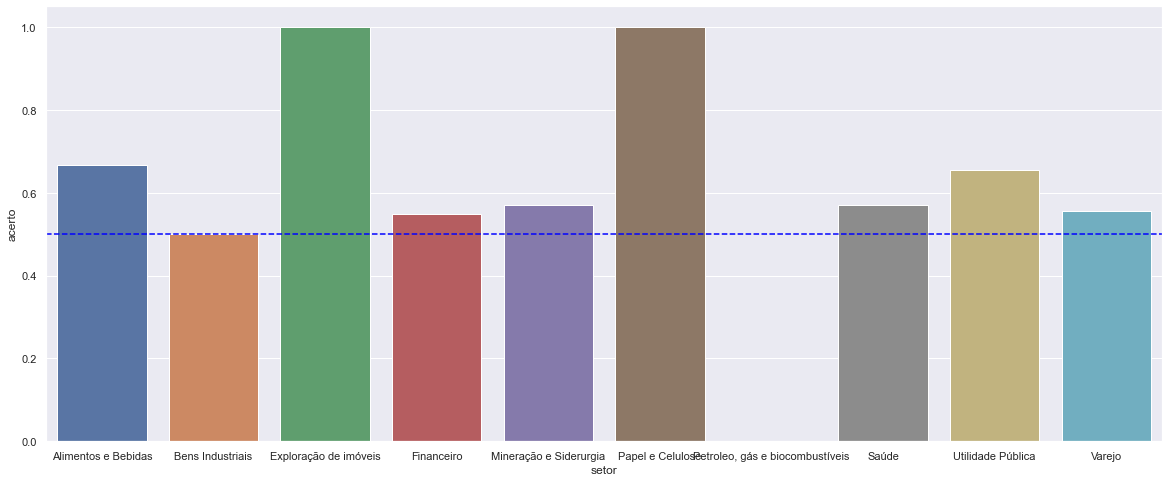

In [39]:
fechadas_agrupadas_semestre = fechadas.groupby(['setor', pd.Grouper(key='open_date', freq='1Y')]).e_lucro_bruto.mean().reset_index()

plt.figure(figsize=(20,8))

fechadas_agrupadas_semestre['open_date'] = pd.to_datetime(fechadas_agrupadas_semestre['open_date'])
fechadas_2020 = fechadas_agrupadas_semestre.set_index('open_date').loc['2020'].reset_index()
fechadas_2020['open_date'] = fechadas_2020.open_date.dt.date

sns.barplot(x='setor', y='e_lucro_bruto', data=fechadas_2020)
plt.axhline(y=0.5, color='blue', linestyle='--')

plt.ylabel('acerto')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [40]:
fechadas.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'))

,total_trades,gain_halflife
open_date,,
2019-01-31,15,0.533333
2019-07-31,70,0.685714
2020-01-31,49,0.653061
2020-07-31,88,0.602273
2021-01-31,37,0.621622
2021-07-31,39,0.615385
2022-01-31,39,0.538462
2022-07-31,79,0.582278


In [42]:
# fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
# fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
# fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE') & (fechadas.days_open <= fechadas.halflife)]
# todos_indices = fechadas_stop_var.index.tolist() + fechadas_halflife.index.tolist() + fechadas_retorno.index.tolist()


In [44]:
# fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE')]

todos_indices = fechadas_stop_var.index.tolist()  + fechadas_retorno.index.tolist()


In [45]:
seen = set()
dupes = [x for x in todos_indices if x in seen or seen.add(x)]    

In [46]:
set(fechadas.index.tolist()) - set(todos_indices)

set()

In [47]:
fechadas.shape

(416, 35)

In [53]:
fechadas_retorno_semestre = fechadas_retorno.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_retorno_media = ('e_lucro_bruto', 'mean'),
)
fechadas_retorno_semestre['loss_retorno_media'] = 1-fechadas_retorno_semestre['gain_retorno_media']

fechadas_retorno_semestre

,total_trades,gain_retorno_media,loss_retorno_media
open_date,,,
2019-01-31,4,1.000000,0.000000
2019-07-31,26,1.000000,0.000000
2020-01-31,21,0.952381,0.047619
2020-07-31,30,0.900000,0.100000
2021-01-31,11,1.000000,0.000000
2021-07-31,17,0.941176,0.058824
2022-01-31,10,0.900000,0.100000
2022-07-31,19,0.947368,0.052632


In [54]:
fechadas_var_semestre = fechadas_stop_var.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)
fechadas_var_semestre['loss_var'] = 1-fechadas_var_semestre['gain_var']

fechadas_var_semestre

,total_trades,gain_var,loss_var
open_date,,,
2019-01-31,11,0.363636,0.636364
2019-07-31,44,0.500000,0.500000
2020-01-31,28,0.428571,0.571429
2020-07-31,58,0.448276,0.551724
2021-01-31,26,0.461538,0.538462
2021-07-31,22,0.363636,0.636364
2022-01-31,29,0.413793,0.586207
2022-07-31,60,0.466667,0.533333


In [55]:
halflife_semestre = fechadas_halflife.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)

halflife_semestre['loss_halflife'] = 1-halflife_semestre['gain_halflife']

halflife_semestre

NameError: name 'fechadas_halflife' is not defined

# Resumo Pares

In [57]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)

,trades,taxa_acerto,prazo_medio_operacao,retorno_bruto_acum,retorno_liquidi_acum
sorted_pair,,,,,
"(PETR3, PETR4)",14,0.857143,11.285714,0.113114,-0.292217
"(EQTL3, TAEE11)",10,0.800000,14.600000,0.438919,0.137089
"(BRAP4, GGBR4)",9,0.777778,2.888889,0.331671,0.067907
"(CPFE3, EGIE3)",9,0.666667,7.111111,0.153827,-0.107034
"(ELET3, ELET6)",9,0.555556,14.777778,0.167176,-0.097806
"(BRML3, MULT3)",8,0.750000,7.125000,0.259163,0.023764
"(FLRY3, QUAL3)",8,0.750000,10.875000,0.512461,0.268130
"(SBSP3, TAEE11)",8,0.625000,11.750000,-0.120790,-0.347495
"(BBAS3, BBDC4)",7,0.714286,7.714286,0.141944,-0.061804


In [58]:
df_returns.pivot(index='pair', columns='date', values='return').T.to_excel('retornos_VAR05_Quarentena.xlsx')